In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 测试序列生成
def signal_generator(fs, time, signal_range, start_freq, end_freq):
    """
    生成一个持续仿真时间的每秒频率递增的正弦波信号。
    参数：
    fs - 每秒采样点数
    time - 仿真时间（秒）
    signal_range - 信号幅度范围
    start_freq - 起始频率(Hz)
    end_freq - 终止频率(Hz)
    
    返回：
    generated_signal - 生成的信号
    """
    num_samples = fs * time  # 总样本数
    t = np.linspace(0, time, num_samples, endpoint=False)  # 时间序列
    generated_signal = np.zeros_like(t)  # 初始化信号数组

    # 逐秒递增频率，生成正弦波信号
    for i in range(time):
        freq = start_freq + i * (end_freq - start_freq) / time
        samples_per_cycle = fs / freq  # 每个周期的样本数
        num_cycles = int(fs // samples_per_cycle)  # 每秒能容纳的完整周期数

        if num_cycles >= 1:
            cycle_samples = int(num_cycles * samples_per_cycle)  # 完整周期的样本数
            t_segment = np.linspace(0, cycle_samples / fs, cycle_samples, endpoint=False)  # 当前段的时间序列
            sine_segment = np.sin(2 * np.pi * freq * t_segment)  # 生成当前频率的正弦波
            generated_signal[i * fs : i * fs + cycle_samples] = np.round(sine_segment * signal_range)  # 插入信号

    return generated_signal

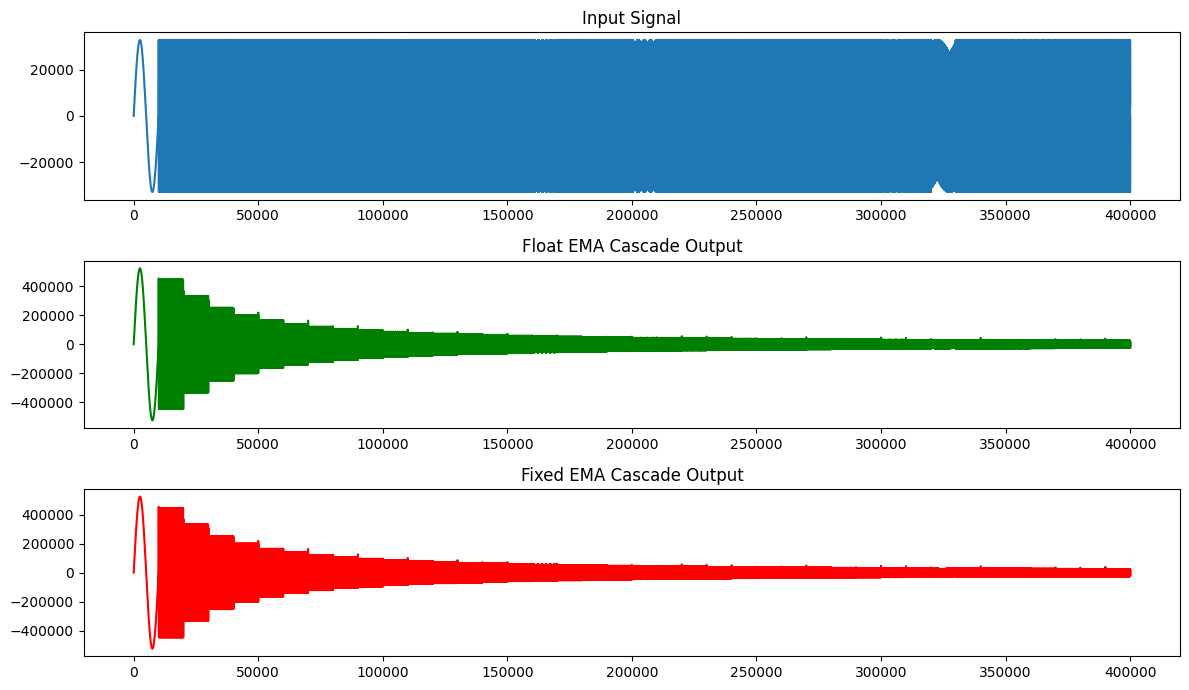

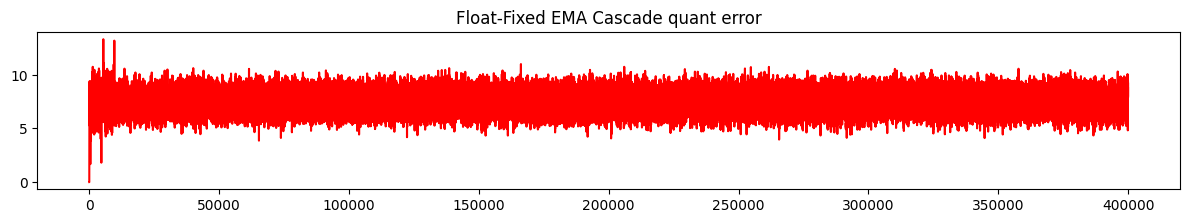

Average Quantization Error: 7.5089355


In [3]:
# 环形噪声测试
def circle_float(x, alpha):
    y = x.copy().astype(np.float32)
    w0 = np.zeros_like(y)
    w0[0] = y[0]
    for n in range(1, len(y)):
        w0[n] = w0[n-1] * (1 - alpha) + y[n]
    
    return w0

def circle_fixed(x, alpha):
    N = np.abs(np.log2(alpha*0.5)).astype(np.int32)
    x = x.astype(np.int32)
    # y_new is actually output
    # direct 2nd order IIR implementation
    w0 = np.zeros(len(x)).astype(np.int32)
    w0[0] = x[0]
    for n in range(1, len(x)):
        w0[n] = x[n] + w0[n-1] - (w0[n-1] >> (N-1))
    return w0.astype(np.float32)

# 生成一个从start_freq(Hz)到end_freq(Hz)的正弦波信号，1s一个频率段
start_freq = 1      # 起始频率
end_freq = 2500     # 终止频率
fs = 10000  # 每秒采样点数
time = 40  # 仿真时间
signal_range = 32767
x = signal_generator(fs, time, signal_range, start_freq, end_freq)

alpha = [0.5**4]

# 一阶的量化误差分析测试
y_float = circle_float(x, alpha[0])
y_fixed = circle_fixed(x, alpha[0])

# 绘图比较
plt.figure(figsize=(12, 7))
plt.subplot(3, 1, 1)
plt.plot(x, label='Input Signal')
plt.title('Input Signal')
plt.subplot(3, 1, 2)
plt.plot(y_float, label='Float EMA Cascade', color='g')
plt.title('Float EMA Cascade Output')
plt.subplot(3, 1, 3)
plt.plot(y_fixed, label='Fixed EMA Cascade', color='r')
plt.title('Fixed EMA Cascade Output')
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 3)
plt.plot(np.abs(y_float-y_fixed), label='quane error', color='r')
plt.title('Float-Fixed EMA Cascade quant error')
plt.tight_layout()
plt.show()

print("Average Quantization Error:", np.mean(np.abs(y_float - y_fixed)))

# 反馈增益测试
测试G(z) = 1 / (1+a1z1+a2z2)在不同频率下的增益表现(模值)


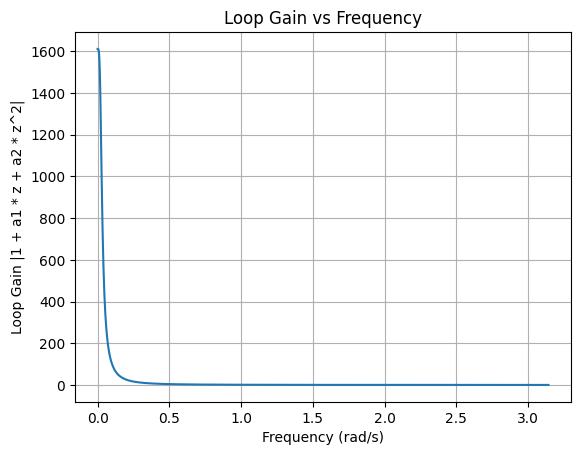

In [6]:
# 反馈增益测试
# g = 1 / (1 + a1z1 + a2z2)

from scipy.signal import butter
import numpy as np
import matplotlib.pyplot as plt

fs = 10000
fc = 40
b, a = butter(2, fc / (fs / 2), btype='low')
a1, a2 = a[1], a[2]

# 频率范围：从0到2π
omega = np.linspace(0, np.pi, 1000)

# 计算z = e^(jω)
z = np.exp(1j * omega)

# 计算环路增益 |1 + a1 * z + a2 * z^2|
G = 1 / np.abs(1 + a1 * z + a2 * z**2)

# 绘制环路增益随频率变化的图像
plt.plot(omega, G)
plt.title('Loop Gain vs Frequency')
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Loop Gain |1 + a1 * z + a2 * z^2|')
plt.grid(True)
plt.show()